# Hierarchical optimization

In this notebook we illustrate how to do hierarchical optimization in pyPESTO.

A frequent problem occuring in parameter estimation for dynamical systems is that the objective function takes a form

$$ J(\theta, s, b, \sigma^2) = \sum_i \left[\log(2\pi\sigma_i^2) + \frac{(\bar y_i - (s_iy_i(\theta) + b_i))^2}{\sigma_i^2}\right] $$

with data $\bar y_i$, parameters $\eta = (\theta,s,b,\sigma^2)$, and ODE simulations $y(\theta)$. Here, we consider a Gaussian noise model, but also others (e.g. Laplace) are possible. The point of interest here is that we can split up the parameter vector $\eta$ into "dynamic" parameters $\theta$ which are required for simulating the ODE, and "static" parameters $s,b,\sigma^2$ only required to scale the simulations and formulate the objective function. As usually simulating the ODE is the time-critical part, one can exploit this separation of parameters by formulating an outer optimization problem in which $\theta$ is optimized, and an inner optimization problem in which $s,b,\sigma^2$ are optimized conditioned on $\theta$. This approach has shown to have superior performance to the classic aproach of jointly optimizting $\eta$. 

In pyPESTO, we have implemented the algorithms developed in [Loos et al.; Hierarchical optimization for the efficient parametrization of ODE models; Bioinformatics 2018](https://academic.oup.com/bioinformatics/article/34/24/4266/5053308) (covering Gaussian and Laplace noise models with gradients computed via forward sensitivity analysis) and [Schmiester et al.; Efficient parameterization of large-scale dynamic models based on relative measurements; Bioinformatics 2019](https://academic.oup.com/bioinformatics/article/36/2/594/5538985) (extending to offset parameters and adjoint sensitivity analysis).

In [1]:
import os
import time

import amici
import matplotlib.pyplot as plt
import numpy as np
import petab

import pypesto
from pypesto.hierarchical.solver import (
    AnalyticalInnerSolver,
    NumericalInnerSolver,
)
from pypesto.optimize.options import OptimizeOptions
from pypesto.petab import PetabImporter

We consider a version of the [Boehm et al.; Journal of Proeome Research 2014] model, modified to include scalings $s$, offsets $b$, and noise parameters $\sigma^2$.

In [2]:
folder_base = "./"
model_name = "Boehm_JProteomeRes2014_Hierarchical"

# the yaml configuration file links to all needed files
yaml_config = os.path.join(folder_base, model_name, model_name + '.yaml')

# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

The PEtab observable table contains placeholders for scaling parameters $s$ (`observableParameter1_{pSTAT5A_rel,pSTAT5B_rel,rSTAT5A_rel}`), offsets $b$ (`observableParameter2_{pSTAT5A_rel,pSTAT5B_rel,rSTAT5A_rel}`), and noise parameters $\sigma^2$ (`noiseParameter1_{pSTAT5A_rel,pSTAT5B_rel,rSTAT5A_rel}`) that are overridden by the `{observable,noise}Parameters` column in the measurement table.

In [3]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(petab_problem.observable_df)

,observableName,observableFormula,noiseFormula,observableTransformation,noiseDistribution
observableId,,,,,
pSTAT5A_rel,NaN,observableParameter2_pSTAT5A_rel + observableParameter1_pSTAT5A_rel * (100 * pApB + 200 * pApA * specC17) / (pApB + STAT5A * specC17 + 2 * pApA * specC17),noiseParameter1_pSTAT5A_rel,lin,normal
pSTAT5B_rel,NaN,observableParameter2_pSTAT5B_rel + observableParameter1_pSTAT5B_rel * -(100 * pApB - 200 * pBpB * (specC17 - 1)) / ((STAT5B * (specC17 - 1) - pApB) + 2 * pBpB * (specC17 - 1)),noiseParameter1_pSTAT5B_rel,lin,normal
rSTAT5A_rel,NaN,observableParameter2_rSTAT5A_rel + observableParameter1_rSTAT5A_rel * (100 * pApB + 100 * STAT5A * specC17 + 200 * pApA * specC17) / (2 * pApB + STAT5A * specC17 + 2 * pApA * specC17 - STAT5B * (specC17 - 1) - 2 * pBpB * (specC17 - 1)),noiseParameter1_rSTAT5A_rel,lin,normal


Parameters to be optimized in the inner problem are selected via the PEtab parameter table by setting a value in the non-standard column `parameterType` (`offset` for offset parameters, `scaling` for scaling parameters, and `sigma` for sigma parameters):

In [4]:
petab_problem.parameter_df

,parameterName,parameterScale,lowerBound,upperBound,nominalValue,estimate,parameterType,hierarchical
parameterId,,,,,,,,
Epo_degradation_BaF3,"EPO_{degradation,BaF3}",log10,0.00001,100000,0.026983,1,NaN,0
k_exp_hetero,"k_{exp,hetero}",log10,0.00001,100000,0.000010,1,NaN,0
k_exp_homo,"k_{exp,homo}",log10,0.00001,100000,0.006170,1,NaN,0
k_imp_hetero,"k_{imp,hetero}",log10,0.00001,100000,0.016368,1,NaN,0
k_imp_homo,"k_{imp,homo}",log10,0.00001,100000,97749.379402,1,NaN,0
k_phos,k_{phos},log10,0.00001,100000,15766.507020,1,NaN,0
ratio,ratio,lin,-5.00000,5,0.693000,0,NaN,0
offset_pSTAT5A_rel,NaN,lin,-100.00000,100,0.000000,0,offset,0
offset_pSTAT5B_rel,NaN,lin,-100.00000,100,0.000000,0,offset,0


In [5]:
# Create pypesto Objectives with and without hierarchical optimization
importer = PetabImporter(
    petab_problem, hierarchical=True, validate_petab=False
)
objective = importer.create_objective()
problem = importer.create_problem(objective)
problem.objective.amici_solver.setSensitivityMethod(
    amici.SensitivityMethod_adjoint
)

importer2 = PetabImporter(petab_problem, hierarchical=False)
objective2 = importer2.create_objective()
problem2 = importer2.create_problem(objective2)
problem2.objective.amici_solver.setSensitivityMethod(
    amici.SensitivityMethod_adjoint
)

# Set the same starting point for both
n_starts = 10
startpoints = pypesto.startpoint.latin_hypercube(
    n_starts=n_starts, lb=problem2.lb_full, ub=problem2.ub_full
)
outer_indices = [problem2.x_names.index(x_id) for x_id in problem.x_names]
problem.set_x_guesses(startpoints[:, outer_indices])
problem2.set_x_guesses(startpoints)

options = OptimizeOptions(allow_failed_starts=False)

In [6]:
# Run hierarchical optimization using NumericalInnerSolver
start_time = time.time()
problem.objective.calculator.inner_solver = NumericalInnerSolver()
problem.objective.calculator.inner_solver.n_starts = 1
engine = pypesto.engine.MultiProcessEngine(n_procs=6)
result_num = pypesto.optimize.minimize(
    problem, n_starts=n_starts, engine=engine, options=options
)
print(result_num.optimize_result.get_for_key('fval'))
time_num = time.time() - start_time
print(time_num)

Performing parallel task execution on 6 processes.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 352.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.86it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 106.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s]



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 175.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 147.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 155.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 155.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 147.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.03it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.64it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 94.96it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 359.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.76it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 159.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 157.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 265.14it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.15it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 103.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.96it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 172.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.59it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 145.13it/s]


[143.83075223887792, 162.90203693515508, 162.93084424841263, 232.20112770173958, 232.8294742786511, 233.6624954402912, 234.13977742812753, 235.52350061588726, 235.5235016104142, 281.1884713510685]
10.929971933364868


In [7]:
# Run hierarchical optimization using AnalyticalInnerSolver
start_time = time.time()
problem.objective.calculator.inner_solver = AnalyticalInnerSolver()
engine = pypesto.engine.MultiProcessEngine(n_procs=6)
result_ana = pypesto.optimize.minimize(
    problem, n_starts=n_starts, engine=engine, options=options
)
print(result_ana.optimize_result.get_for_key('fval'))
time_ana = time.time() - start_time
print(time_ana)

Performing parallel task execution on 6 processes.
  0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s][Warning] AMICI:NaN: AMICI encountered a NaN value for xBdot[0] (STAT5A)
[Warning] AMICI:NaN: AMICI encountered a NaN value for p[8] (observableParameter1_pSTAT5A_rel)
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:CVODEA:CVodeB:OTHER: AMICI ERROR: in module CVODEA in function CVodeB : Error occured while integrating backward problem # 0 
[Warning] AMICI:simulation: AMICI backward simulation failed when trying to solve until t = 200.000000 (see message above):
AMICI failed to integrate the backward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value for xBdot[0] (STAT5A)
[Warning] AMICI:NaN: AMICI encountered a N

[147.35067615714965, 162.92295904493344, 162.92299363092312, 186.38735649166952, 186.38738298630813, 186.38739831083146, 186.38740726096987, 186.3874089082442, 186.38741444915317, 197.1974863982029]
10.055277824401855


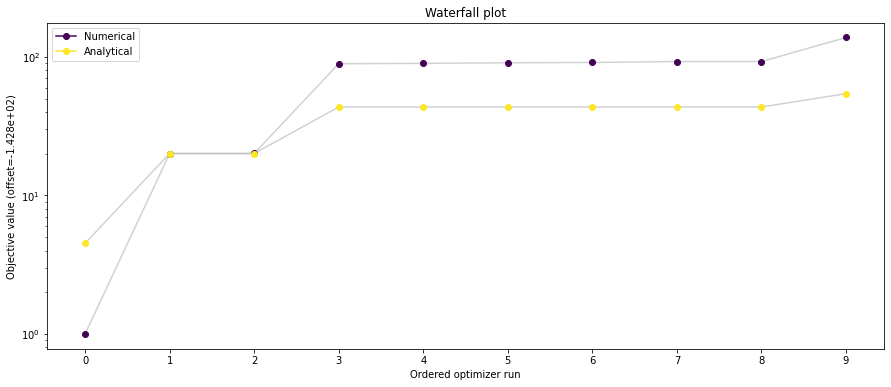

In [8]:
# Waterfall plot - analytical vs numerical inner solver
pypesto.visualize.waterfall(
    [result_num, result_ana], legends=['Numerical', 'Analytical'], size=(15, 6)
)
plt.savefig("num_ana.png")

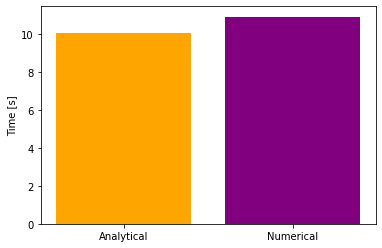

In [9]:
# Time comparison - analytical vs numerical inner solver
import matplotlib.pyplot as plt

ax = plt.bar(x=[0, 1], height=[time_ana, time_num], color=['orange', 'purple'])
ax = plt.gca()
ax.set_xticks([0, 1])
ax.set_xticklabels(['Analytical', 'Numerical'])
ax.set_ylabel('Time [s]')
plt.savefig("num_ana_time.png")

In [10]:
# Run standard optimization
start_time = time.time()
engine = pypesto.engine.MultiProcessEngine(n_procs=6)
result_ord = pypesto.optimize.minimize(
    problem2, n_starts=n_starts, engine=engine
)
print(result_ord.optimize_result.get_for_key('fval'))
time_ord = time.time() - start_time
print(time_ord)

Performing parallel task execution on 6 processes.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.89it/s]


[134.1852144035424, 147.35070484772933, 162.89386730047514, 190.2747098163547, 194.33615465269511, 235.52321756888963, 235.5235016075326, 235.52350160882273, 261.0235941133727, 261.023765038744]
16.751909494400024


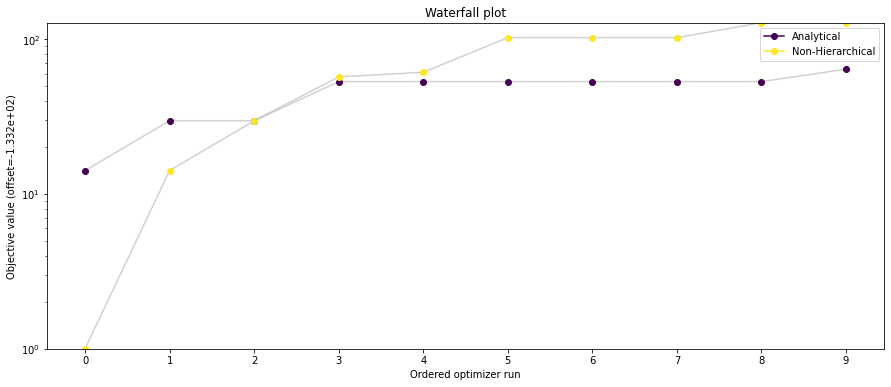

In [11]:
# Waterfall plot - hierarchical optimization with analytical inner solver vs standard optimization
pypesto.visualize.waterfall(
    [result_ana, result_ord],
    legends=['Analytical', 'Non-Hierarchical'],
    size=(15, 6),
)
plt.savefig("ana_ord.png")

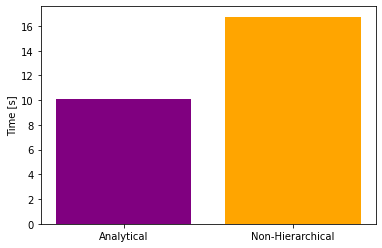

In [12]:
# Time comparison - hierarchical optimization with analytical inner solver vs standard optimization
import matplotlib.pyplot as plt

ax = plt.bar(x=[0, 1], height=[time_ana, time_ord], color=['purple', 'orange'])
ax = plt.gca()
ax.set_xticks([0, 1])
ax.set_xticklabels(['Analytical', 'Non-Hierarchical'])
ax.set_ylabel('Time [s]')
plt.savefig("ana_ord_time.png")

In [13]:
# Run hierarchical optimization with analytical inner sovler and forward sensitivities
start_time = time.time()
problem.objective.calculator.inner_solver = AnalyticalInnerSolver()
problem.objective.amici_solver.setSensitivityMethod(
    amici.SensitivityMethod_forward
)
engine = pypesto.engine.MultiProcessEngine(n_procs=6)
result_ana_fw = pypesto.optimize.minimize(
    problem, n_starts=n_starts, engine=engine
)
print(result_ana_fw.optimize_result.get_for_key('fval'))
time_ana_fw = time.time() - start_time
print(time_ana_fw)

Performing parallel task execution on 6 processes.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.73it/s]


[147.35067564635756, 162.92299401832287, 162.92837662054126, 186.387357300531, 186.38738331812215, 186.38739245826295, 186.38739705059467, 186.38740760251994, 186.38740882516618, 186.3874143109516]
4.451628923416138


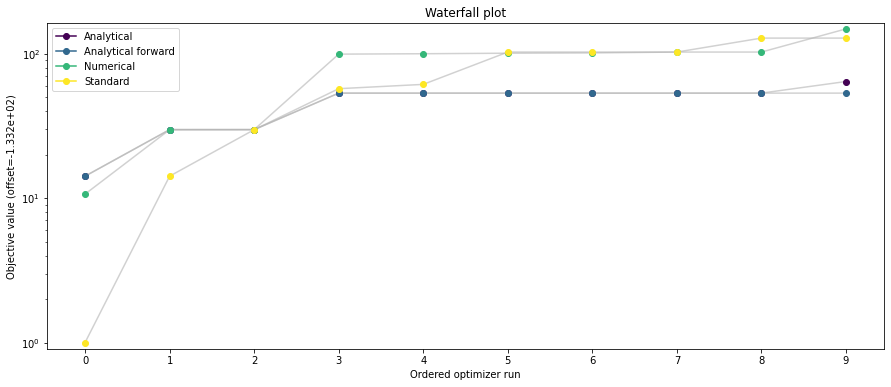

In [14]:
# Waterfall plot - compare all scenarios
pypesto.visualize.waterfall(
    [result_ana, result_ana_fw, result_num, result_ord],
    legends=['Analytical', 'Analytical forward', 'Numerical', 'Standard'],
    size=(15, 6),
)
plt.savefig("all.png")

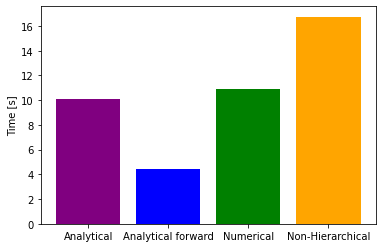

In [15]:
# Time comparison of all scenarios
import matplotlib.pyplot as plt

ax = plt.bar(
    x=[0, 1, 2, 3],
    height=[time_ana, time_ana_fw, time_num, time_ord],
    color=['purple', 'blue', 'green', 'orange'],
)
ax = plt.gca()
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(
    ['Analytical', 'Analytical forward', 'Numerical', 'Non-Hierarchical']
)
ax.set_ylabel('Time [s]')
plt.savefig("all_time.png")

In [17]:
problem.objective.calculator.inner_problem.get_x_ids()

['sd_pSTAT5A_rel',
 'sd_pSTAT5B_rel',
 'sd_rSTAT5A_rel',
 'scaling_pSTAT5A_rel',
 'scaling_pSTAT5B_rel',
 'scaling_rSTAT5A_rel']